Files already downloaded and verified
Files already downloaded and verified
Starting Training Loop...
reset epoch statistics
iteration 0 current loss: 3.109332799911499 current acc: 0.0859375
iteration 1 current loss: 2.60288667678833 current acc: 0.154296875
iteration 2 current loss: 2.811790704727173 current acc: 0.16796875
iteration 3 current loss: 2.59289288520813 current acc: 0.19140625
iteration 4 current loss: 2.3167896270751953 current acc: 0.21015625
iteration 5 current loss: 2.1298484802246094 current acc: 0.22916666666666666
iteration 6 current loss: 2.0636816024780273 current acc: 0.23604910714285715
iteration 7 current loss: 2.4784739017486572 current acc: 0.2421875
iteration 8 current loss: 2.2159972190856934 current acc: 0.2482638888888889
iteration 9 current loss: 2.2135791778564453 current acc: 0.25625
iteration 10 current loss: 2.185857057571411 current acc: 0.26029829545454547
iteration 11 current loss: 2.1716220378875732 current acc: 0.2643229166666667
iteration 12 

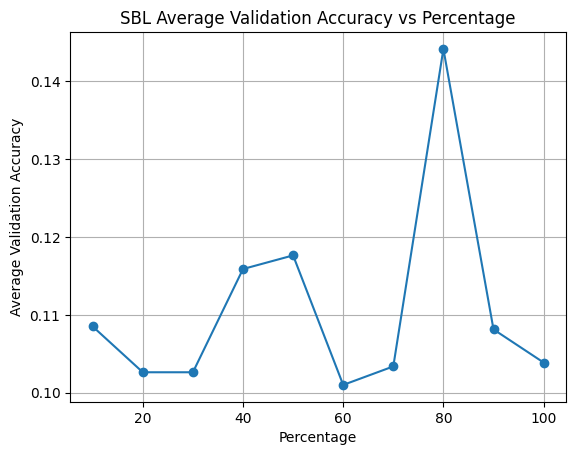

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import sys
import numpy as np
from matplotlib import pyplot as plt



learning_rate = 0.0001
batch_size = 256
weight_decay = 0.04

batch_size = batch_size
image_size = 96

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


train_dataset = STL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = STL10(root='./data', split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


num_train = len(train_dataset)
nc = 3
ndf = 96
num_epochs = 100
lr=learning_rate
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Lists to store data for plotting
percentages = []
avg_val_accs = []

# Training loop for different percentages of labeled data
for percent in range(10, 101, 10):  # Train on 10%, 20%, ..., 100% of the labeled data
    # Calculate the number of samples to use
    num_samples = int(num_train * percent / 100)
    
    # Create a subset of the dataset with the desired percentage
    subset_train_dataset = torch.utils.data.Subset(train_dataset, indices=range(num_samples))
    subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)




    model = Encoder(ngpu=0, dim_z=64, num_classes=10).to(device)
    model.apply(weights_init)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    
    
    best_loss = float('inf')
    best_model_state = None
    num_train = len(train_dataset)
    
    all_loss = []
    all_acc = []
    all_correct = 0
    train_running_total = 0
    
    epoch_loss = []
    epoch_acc = []
    
    val_loss = []
    val_acc = []
    val_running_total = 0
        

    
    print("Starting Training Loop...")
    
    for epoch in range(num_epochs):
        print('reset epoch statistics')
        epoch_correct = 0
        epoch_loss_val = 0
    
        model.train()
    
        for i, (data, labels) in enumerate(train_loader, 0):
            data_real = data.to(device)
            labels = labels.to(device)
    
            optimizer.zero_grad()
            
            output = model(data_real)
    
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
    
            predicted = torch.argmax(output.data, dim=1).to(device)
    	
                   
     
            correct = (predicted == labels).sum().item()
    
            all_loss.append(loss.item())
            
            all_correct += correct
            train_running_total += labels.size(0)
    
            all_accuracy = all_correct / train_running_total
            all_acc.append(all_accuracy)
    
            print(f'iteration {i} current loss: {loss.item()} current acc: {all_accuracy}')    
    
            epoch_correct += correct
            epoch_loss_val += loss.item()
                
    
        epoch_accuracy = epoch_correct / num_train
        epoch_acc.append(epoch_accuracy)
    
        avg_epoch_loss = epoch_loss_val / len(train_loader)
        epoch_loss.append(avg_epoch_loss)
    
        print(f'\t\tEpoch {epoch}/{num_epochs} complete. Epoch loss {avg_epoch_loss} Epoch accuracy {epoch_accuracy}')    
    
        
        # Validation loop
        model.eval()
        with torch.no_grad():
            val_correct = 0
            val_loss_value = 0
    
            for data, labels in test_loader:
                data_real = data.to(device)
                labels = labels.to(device)
    
                output = model(data_real)
                v_loss = criterion(output, labels)
    
                predicted = torch.argmax(output.data, dim=1).to(device)
                val_correct += (predicted == labels).sum().item()
                val_loss_value += v_loss.item()
    
            val_accuracy = val_correct / len(test_dataset)
            val_acc.append(val_accuracy)
            
            avg_val_loss = val_loss_value / len(test_loader)
            val_loss.append(avg_val_loss)
    
            print(f"\t\tValidation Epoch {epoch}, Validation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}, Percentage of Labeled Data: {percent}")
    
            
            # Update best model if necessary
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = model.main.state_dict()
    
    # Record avg val acc across all epochs for each percent
    percentages.append(percent)
    avg_val_accs.append(sum(val_acc) / len(val_acc))
    print(f'percent {percent}')
    print(f'avg val acc {sum(val_acc) / len(val_acc)}')

plt.plot(percentages, avg_val_accs, marker='o')
plt.xlabel('Percentage')
plt.ylabel('Average Validation Accuracy')
plt.title('SBL Average Validation Accuracy vs Percentage')
plt.grid(True)
plt.savefig('../models/sbl_acc_per.png')
np.save('../models/sbl_avg_val_accs_{}_{}_{}.npy'.format(learning_rate, batch_size, weight_decay), avg_val_accs)

In [8]:
percentages

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [9]:
avg_val_accs

[0.2205,
 0.180125,
 0.16591666666666668,
 0.21629166666666666,
 0.20758333333333334,
 0.21595833333333334,
 0.210125,
 0.18916666666666668,
 0.18975,
 0.17637499999999998]

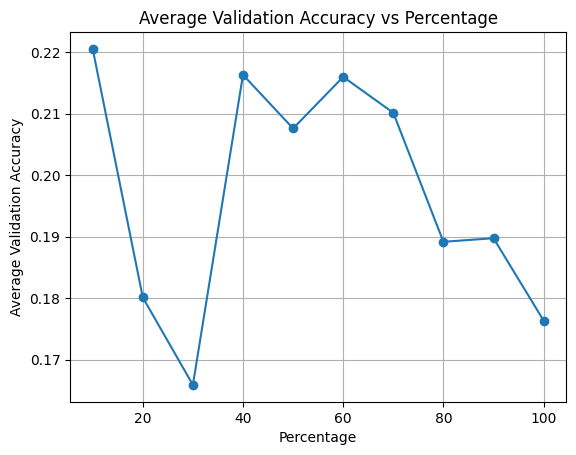

In [16]:

np.save('sbl_avg_val_accs_{}_{}_{}.npy'.format(learning_rate, batch_size, weight_decay), avg_val_accs)

In [25]:
!wandb login --relogin

wandb: ERROR Find detailed error logs at: /data/users2/jwardell1/dcgan-project/python_nbs/wandb/debug-cli.jwardell1.log
Error: Connection to wandb service failed: [Errno 111] Connection refused. 
